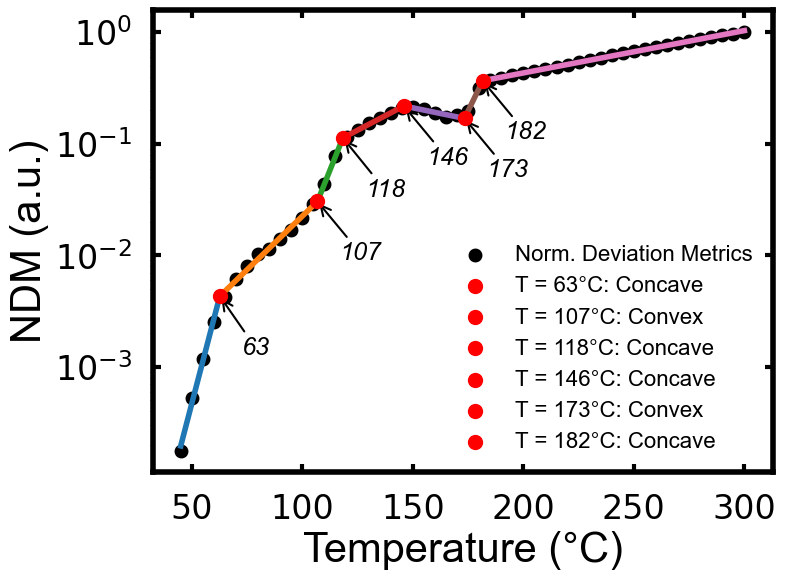

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import pwlf  # Piecewise linear regression library

# Load the data
workdir = 'Q:/My Drive/Characterization/UV-vis insitu/EH-IDTBr/' #Copy and paste directory
data = pd.read_excel(workdir + 'table3.xlsx', header=None) #Excel file for NDM

# Read and clean data
x = pd.to_numeric(data.iloc[1:, 0], errors='coerce').values  # Temperature (°C)
y = pd.to_numeric(data.iloc[1:, 3], errors='coerce').values  # NDM (a.u.)
y_log = np.log(y)  # Apply log transformation

# Handle NaNs by removing them
mask = ~np.isnan(x) & ~np.isnan(y_log)
x = x[mask]
y = y[mask]
y_log = y_log[mask]

# Perform piecewise linear regression using pwlf
def detect_piecewise_regression_pwlf(x, y, num_segments=7):
    pwlf_model = pwlf.PiecewiseLinFit(x, y)
    
    breakpoints = pwlf_model.fit(num_segments) # Fit the model with the number of breakpoints determined by BIC 
    
    # Extract slopes and intercepts for each segment
    slopes = pwlf_model.slopes
    intercepts = pwlf_model.intercepts
    
    return pwlf_model, breakpoints, slopes, intercepts


# Detect piecewise regression breakpoints
pwlf_model, breakpoints, slopes, intercepts = detect_piecewise_regression_pwlf(x, y_log)

# Convert breakpoints and predicted y values back to linear scale
breakpoints = np.array(breakpoints)
y_breakpoints = np.exp(pwlf_model.predict(breakpoints))  # Predicted y values at breakpoints on linear scale


# Font settings
font_1 = FontProperties(family='Arial', style='normal', size=30)
font_2 = FontProperties(family='Arial', style='italic', size=18)

# Choose a color map
colors = plt.cm.tab10  # Tab10 color map

# Plot results with segments
plt.figure(figsize=(8, 6))
plt.rcParams['axes.linewidth'] = 4

# Plot the original data points on a linear scale
plt.scatter(x, y, color='black', linewidth=4, marker='o', label='Norm. Deviation Metrics')

# Plot each segment, calculate R², and prepare legend annotations
legend_labels = []  # Store legend entries

for i in range(len(breakpoints) - 1):
    # Extend each segment slightly beyond its boundaries
    x_segment = np.linspace(breakpoints[i], breakpoints[i+1], 100)  # Segment range
    y_segment_log = pwlf_model.predict(x_segment)  # Predicted y in log scale
    y_segment = np.exp(y_segment_log)  # Convert to linear scale for plotting
    
    # Extract slope and intercept for the segment
    slope = slopes[i]
    intercept = intercepts[i]
    
    # Plot the segment
    plt.plot(x_segment, y_segment, color=colors(i % 10), linewidth=4)


# Add breakpoint curvature annotations to the legend
for i, bp in enumerate(breakpoints[1:-1]):  # Skip the first and last breakpoints
    slope_before = slopes[i]
    slope_after = slopes[i + 1]
    
    # Determine curvature
    curvature = "Convex" if slope_after > slope_before else "Concave"

    # Highlight the breakpoint with a red circle
    y_bp = y_breakpoints[i + 1]  # Predicted y at the breakpoint
    plt.scatter(bp, y_bp, color='red', s=100, zorder=5, label=f'T = {bp:.0f}°C: {curvature}')
    plt.annotate(f'{bp:.0f}', xy=(bp, y_bp), xytext=(bp + 10, y_bp * 0.3),
                 fontproperties=font_2, color='black',
                 arrowprops=dict(arrowstyle='->', facecolor='black', lw=1.5))

# Labeling the plot
plt.xlabel('Temperature (°C)', fontproperties=font_1)
plt.ylabel('NDM (a.u.)', fontproperties=font_1)
plt.yscale('log')
plt.legend(frameon=False, prop=FontProperties(family='Arial', size=16))
plt.tick_params(axis='both', which='major', labelsize=24, labelcolor='black', length=6, width=3, pad=15, direction='in', bottom=True, top=True, left=True, right=True)
#plt.savefig(workdir + 'EH-IDTBr.jpeg', dpi=600, bbox_inches='tight')
plt.show()
